## Prerequisities

In [ ]:
!pip install --quiet shap

     |████████████████████████████████| 569 kB 7.8 MB/s 


In [ ]:
# install prerequisities

import gdown
import pandas as pd
import numpy as np
import nltk
import string
import re
import math
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats
from collections import Counter
from textblob import Word
from sklearn.linear_model import LinearRegression

nltk.download("popular", quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
# make stopwords
stopwords = stopwords.words('english')
# make lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
# Load data from drive
def load_data(link, index= None):
  # Download data from gdrive
  meta_url = 'https://drive.google.com/uc?export=download&confirm=pbef&id='
  url = meta_url + link
  output = 'data.csv'
  gdown.download(url, output, quiet=True)
  data = pd.read_csv(output, on_bad_lines='skip')
  return data

In [ ]:
# Clean the employment gender data
def employment_gender(link):
  df = load_data(link)
  df = df.loc[1:]
  new_header = df.iloc[0]
  df = df[1:]
  df.columns = new_header.tolist()
  df.index = np.arange(1, len(df) + 1)
  return df

In [ ]:
# Spelling correction using textblob
def correct_word_spelling(word):
    word = Word(word)
    result = word.correct()
    return result

In [ ]:
# Function to plot time series
def plot_timeseries(axes, x, y, color, xlabel, ylabel):
  axes.plot(x, y, color=color)
  axes.set_xlabel(xlabel)
  axes.set_ylabel(ylabel, color=color)
  axes.tick_params('y', colors=color)

In [ ]:
# function to clean text
def clean_text(text, correct=True):
  # replace some words
  text = text.replace("BA/BS","Bachelor Art Science")
  text = text.replace("BS","Bachelor Science")
  text = text.replace("BA","Bachelor Art")
  text = text.replace(" and/or", "")
  # remove punctuation
  text = "".join([word.lower() for word in text if word not in string.punctuation+"’"])
  # remove non character text
  tokens = re.split('\W+', text)
  # remove stopwords and lemmatize word
  text = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]
  # spelling correction
  if correct:
    text = [correct_word_spelling(word) for word in text]
  return text

## Preparation on employement indicator data

Include:
* **Preparation**
* **Processing**
* **Cleansing**

In [ ]:
df = load_data("1g_zyzr9CX5p8W8X8Wx5osVQkMY8334Lh")
df.drop(0, inplace=True) # Drop first columns -> id
df['Value'] = df['Value'].astype(float)

In [ ]:
df.head(2) # Preview

,Country Name,Country ISO3,Year,Indicator Name,Indicator Code,Value
1,Indonesia,IDN,2015,Firms with female top manager (% of firms),IC.FRM.FEMM.ZS,22.1
2,Indonesia,IDN,2009,Firms with female top manager (% of firms),IC.FRM.FEMM.ZS,31.2


In [ ]:
# Take the data indicator which contains gender comparation (male-female)
df_gender = df[df["Indicator Name"].str.contains("male")]

In [ ]:
# Columns 0 and 1 contained country name and id, which the number of unique is 1 -> Indonesia.
# We can drop them and the indicator name.
df_gender.iloc[:,0].nunique() & df_gender.iloc[:,1].nunique()

1

In [ ]:
# Drop irrelevant columns
df_drop = df_gender.drop(df_gender.iloc[:,[0,1,3]].columns, axis=1)

In [ ]:
# Pivotting on the indicator code and value
pivot_df = df_drop.pivot(index='Year', columns='Indicator Code',values='Value').iloc[41:]
pivot_df.head()

Indicator Code,IC.FRM.FEMM.ZS,IC.FRM.FEMO.ZS,SE.ADT.1524.LT.FE.ZS,SE.ADT.1524.LT.MA.ZS,SE.ADT.LITR.FE.ZS,SE.ADT.LITR.MA.ZS,SE.PRE.ENRR.FE,SE.PRE.ENRR.MA,SE.PRM.CMPT.FE.ZS,SE.PRM.CMPT.MA.ZS,...,SP.POP.AG03.FE.IN,SP.POP.AG03.MA.IN,SP.POP.AG04.FE.IN,SP.POP.AG04.MA.IN,SP.POP.AG05.FE.IN,SP.POP.AG05.MA.IN,SP.RUR.TOTL.FE.ZS,SP.RUR.TOTL.MA.ZS,SP.URB.TOTL.FE.ZS,SP.URB.TOTL.MA.ZS
Year,,,,,,,,,,,,,,,,,,,,,
2001,NaN,NaN,NaN,NaN,NaN,NaN,24.882030,24.031130,94.167458,93.357780,...,2127032.0,2198491.0,2135417.0,2207710.0,2142090.0,2215158.0,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN,NaN,24.726709,24.092939,95.384338,94.734100,...,2145925.0,2220207.0,2154741.0,2229744.0,2161446.0,2237373.0,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,NaN,NaN,NaN,26.490709,24.991150,95.680519,95.638657,...,2164117.0,2242093.0,2173934.0,2251903.0,2181218.0,2259805.0,NaN,NaN,NaN,NaN
2004,NaN,NaN,98.54216,98.867081,86.799591,94.03508,28.189520,25.891350,96.359207,94.858833,...,2178620.0,2263932.0,2192363.0,2274597.0,2200806.0,2282660.0,NaN,NaN,NaN,NaN
2005,NaN,NaN,NaN,NaN,NaN,NaN,32.061291,31.035400,95.082039,93.495461,...,2195919.0,2289176.0,2209567.0,2298576.0,2219780.0,2306482.0,26.652144,27.411229,23.145834,22.790793


In [ ]:
# Checking the null percentage on the data
null_percentage = []
for i in pivot_df.columns:
  null_percentage.append(round(pivot_df[i].isnull().sum()*100/pivot_df.shape[0],2))
  
pd.Series(null_percentage).sort_values(ascending=False)[:50:10]

60     95.24
1      90.48
152    85.71
51     76.19
95     71.43
dtype: float64

In [ ]:
# Determine a random threshold (in this case, we take 50%).
# Check the columns that have more than the threshold, and drop it
pivot_df.columns[np.array(null_percentage)<50][:10]

Index(['SE.PRE.ENRR.FE', 'SE.PRE.ENRR.MA', 'SE.PRM.CMPT.FE.ZS',
       'SE.PRM.CMPT.MA.ZS', 'SE.PRM.ENRL.FE.ZS', 'SE.PRM.ENRR.FE',
       'SE.PRM.ENRR.MA', 'SE.PRM.GINT.FE.ZS', 'SE.PRM.GINT.MA.ZS',
       'SE.PRM.NENR.FE'],
      dtype='object', name='Indicator Code')

In [ ]:
clean_df = pivot_df[pivot_df.columns[np.array(null_percentage)<50]]

In [ ]:
# Apply iterative imputer to impute missing value
imp_mean = IterativeImputer(random_state=0)
clean_df = pd.DataFrame(imp_mean.fit_transform(clean_df), 
                        columns=clean_df.columns, index=clean_df.index)

In [ ]:
clean_df.to_excel("imputed_indicator.xlsx") 

## Analysis on employment indicator data

In [ ]:
# Manual imputer on missing value from data pattern and based on iterative imputer
imputed_df = load_data("1h4M6Ya9AFBzK1iXYmHEc7d7eOLjniS3Y")
imputed_df.loc[:,"Year"] = imputed_df.Year.astype(int)
imputed_df.head(2)

,Year,SE.PRE.ENRR.FE,SE.PRE.ENRR.MA,SE.PRM.CMPT.FE.ZS,SE.PRM.CMPT.MA.ZS,SE.PRM.ENRL.FE.ZS,SE.PRM.ENRR.FE,SE.PRM.ENRR.MA,SE.PRM.GINT.FE.ZS,SE.PRM.GINT.MA.ZS,...,SP.DYN.SMAM.MA,SG.LAW.OBHB.MR.NO,SP.DYN.TO65.FE.ZS.1,SP.DYN.TO65.MA.ZS.1,SP.POP.1564.FE.IN,SP.POP.1564.MA.IN,HD.HCI.HLOS.MA,HD.HCI.HLOS.FE,SG.DMK.ALLD.FE.ZS,SG.DMK.ALLD.MA.ZS
0,2001,24.882030,24.031130,94.167458,93.35778,48.62186,108.455193,111.005981,107.97810,113.91842,...,27.0,1,70.661428,64.008986,69260465.5,69631713,380.038837,402.135946,10.327778,31.3
1,2002,24.726709,24.092939,95.384338,94.73410,48.62113,108.698853,111.103027,111.70473,117.54551,...,25.6,1,71.278228,64.486552,70340395.0,70792759,381.111880,402.523951,10.711111,31.4


In [ ]:
# Set mapping from indicator code to indicator name
# Select the feature that will be used
code_to_desc = {"Year" : "Year",
"SL.EMP.TOTL.SP.FE.ZS" : "emp_rate_f", "SL.EMP.TOTL.SP.MA.ZS" : "emp_rate_m",

"SL.EMP.SELF.FE.ZS" : "informal_emp_f", "SL.EMP.WORK.FE.ZS" : "formal_emp_f",
"SL.EMP.SELF.MA.ZS" : "informal_emp_m", "SL.EMP.WORK.MA.ZS" : "formal_emp_m",

"SE.PRM.NENR.FE" : "primary_edu_f", "SE.PRM.NENR.MA" : "primary_edu_m",
"SE.SEC.NENR.FE" : "secondary_edu_f", "SE.SEC.NENR.MA" : "secondary_edu_m",
"SE.TER.ENRR.FE" : "tertiary_edu_f", "SE.TER.ENRR.MA" : "tertiary_edu_m",
"SE.TER.CUAT.BA.FE.ZS" : "bachelor_edu_f", "SE.TER.CUAT.BA.MA.ZS" : "bachelor_edu_m",
"SE.TER.CUAT.MS.FE.ZS" : "master_edu_f", "SE.TER.CUAT.MS.MA.ZS" : "master_edu_m",

"SL.TLF.BASC.FE.ZS" : "basic_edu_emp_f", "SL.TLF.BASC.MA.ZS" : "basic_edu_emp_m", 
"SL.TLF.INTM.FE.ZS" : "interm_edu_emp_f", "SL.TLF.INTM.MA.ZS" : "interm_edu_emp_m", 
"SL.TLF.ADVN.FE.ZS" : "advance_edu_emp_f", "SL.TLF.ADVN.MA.ZS" : "advance_edu_emp_m", 

"SE.ADT.LITR.FE.ZS" : "literacy_rate_f", "SE.ADT.LITR.MA.ZS" : "literacy_rate_m",
"SP.DYN.LE00.FE.IN" : "life_expect_f", "SP.DYN.LE00.MA.IN" : "life_expect_m",
"HD.HCI.OVRL.FE" : "HCI_f", "HD.HCI.OVRL.MA" : "HCI_m",
"HD.HCI.HLOS.FE" : "HTS_f", "HD.HCI.HLOS.MA" : "HTS_m",
"SP.DYN.SMAM.FE" : "age_marriage_f", "SP.DYN.SMAM.MA" : "age_marriage_m",
"SG.DMK.ALLD.FE.ZS" : "decision_maker_f", "SG.DMK.ALLD.MA.ZS" : "decision_maker_m",
"SP.DYN.TO65.FE.ZS" : "survival_f", "SP.DYN.TO65.MA.ZS" : "survival_m",
"SP.POP.1564.FE.IN" : "population_f", "SP.POP.1564.MA.IN" : "population_m",

"SP.DYN.AMRT.FE" : "mortality_rate_f", "SH.DYN.AIDS.FE.ZS" : "HIV_f"
}

In [ ]:
use_df = imputed_df[code_to_desc.keys()].drop(0)
use_df.columns = code_to_desc.values()
use_df.head(2)

,Year,emp_rate_f,emp_rate_m,informal_emp_f,formal_emp_f,informal_emp_m,formal_emp_m,primary_edu_f,primary_edu_m,secondary_edu_f,...,age_marriage_f,age_marriage_m,decision_maker_f,decision_maker_m,survival_f,survival_m,population_f,population_m,mortality_rate_f,HIV_f
1,2002,44.243000,79.176002,69.519997,30.48,60.689999,39.310001,90.86566,91.77368,50.48961,...,22.0,25.6,10.711111,31.4,71.278228,64.486552,70340395.0,70792759,167.236,19.0
2,2003,43.830002,78.915001,70.910004,29.09,62.430000,37.570000,89.80657,91.44727,53.10740,...,22.1,25.9,11.133333,31.3,71.895028,64.964118,71404235.0,71921499,165.531,20.3


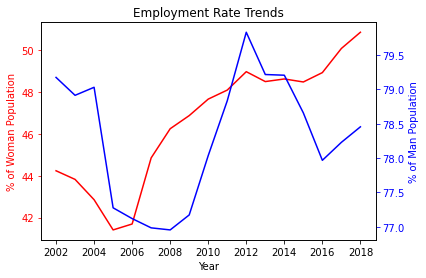

In [ ]:
# Check the employment rate trends from male and female
fig, ax = plt.subplots()
plot_timeseries(ax, use_df['Year'], use_df['emp_rate_f'], 'red',
                'Year', '% of Woman Population')
ax2 = ax.twinx()
plot_timeseries(ax2, use_df['Year'], use_df['emp_rate_m'], 'blue',
                'Year', '% of Man Population')
plt.title("Employment Rate Trends")
plt.show()

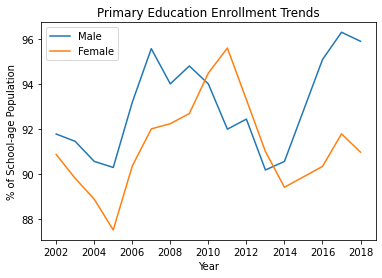

In [ ]:
# Check the education trends from primary until master degree
plt.plot(use_df.Year, use_df['primary_edu_m'], label="Male")
plt.plot(use_df.Year, use_df['primary_edu_f'], label="Female")
plt.xlabel("Year")
plt.ylabel("% of School-age Population")
plt.title("Primary Education Enrollment Trends")
plt.legend()

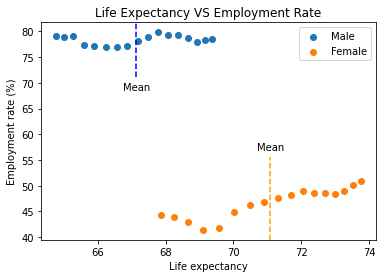

In [ ]:
# Scatterplot between indicator and employment rate
plt.scatter(use_df["life_expect_m"],use_df["emp_rate_m"],label="Male")
plt.scatter(use_df["life_expect_f"],use_df["emp_rate_f"], label="Female")
plt.axvline(use_df["life_expect_m"].mean(), color='blue', linestyle="--", ymin=0.75, ymax=1)
plt.text(use_df["life_expect_m"].mean()-0.4,68.6,'Mean')
plt.axvline(use_df["life_expect_f"].mean(), color='orange', linestyle='--', ymin=0, ymax=0.38)
plt.text(use_df["life_expect_f"].mean()-0.4,57,'Mean')
plt.xlabel("Life expectancy")
plt.ylabel("Employment rate (%)")
plt.title("Life Expectancy VS Employment Rate")
plt.legend()

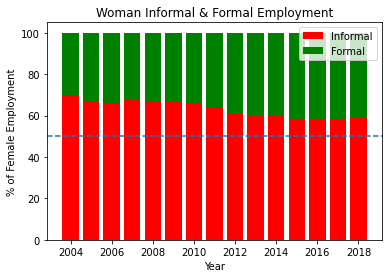

In [ ]:
# Proportion of woman formal and informal employment rate 
tmp = use_df.query("Year>2003")
plt.bar(tmp.Year, tmp['informal_emp_f'], color='r', label='Informal')
plt.bar(tmp.Year, tmp['formal_emp_f'], bottom=tmp['informal_emp_f'], color='g',label='Formal')
plt.axhline(50, linestyle='--')
plt.title("Woman Informal & Formal Employment")
plt.xlabel("Year")
plt.ylabel("% of Female Employment")
plt.legend()
plt.show()

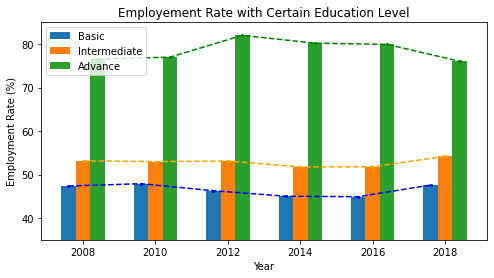

In [ ]:
# Check the employment rate grouped by education level
plt.figure(figsize=(8,4))
tmp = use_df[(use_df.Year%2==0) & (use_df.Year>2006)]
bar_width = 0.4
plt.bar(tmp.Year - bar_width , tmp['basic_edu_emp_f'], bar_width, label='Basic')
plt.plot(tmp.Year - bar_width , tmp['basic_edu_emp_f'], color='blue', 
         marker='o', markersize=2, linestyle='--')
plt.bar(tmp.Year, tmp['interm_edu_emp_f'], bar_width, label='Intermediate')
plt.plot(tmp.Year, tmp['interm_edu_emp_f'], color='orange', 
         marker='o', markersize=2, linestyle='--')
plt.bar(tmp.Year + bar_width , tmp['advance_edu_emp_f'], bar_width, label='Advance')
plt.plot(tmp.Year + bar_width, tmp['advance_edu_emp_f'], color='green', 
         marker='o', markersize=2, linestyle='--')
plt.ylim([35,85])
plt.legend(loc=2)
plt.title("Employement Rate with Certain Education Level")
plt.xlabel("Year")
plt.ylabel("Employment Rate (%)")
plt.show()

In [ ]:
# Make feature and target for regression
feature_list = ['primary_edu_f', 'secondary_edu_f', 'tertiary_edu_f', 'bachelor_edu_f',
           'master_edu_f', 'life_expect_f', 'literacy_rate_f', 'HCI_f',
           'HTS_f', 'age_marriage_f', 'decision_maker_f', 'survival_f',
           'mortality_rate_f', "HIV_f"]
feature = use_df[feature_list]
target = use_df['emp_rate_f']

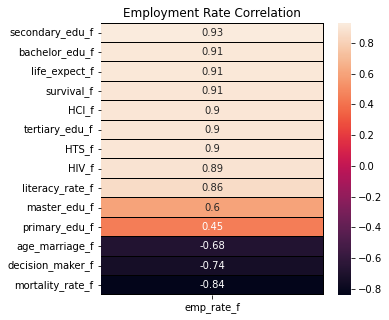

In [ ]:
# Check employment rate correlation with features
plt.figure(figsize=(5,5))
plt.title("Employment Rate Correlation")
sns.heatmap(pd.concat([feature, target], axis=1).corr()[["emp_rate_f"]][:-1].\
            sort_values(by='emp_rate_f', ascending=False), annot=True, linecolor='black', linewidths=0.01)

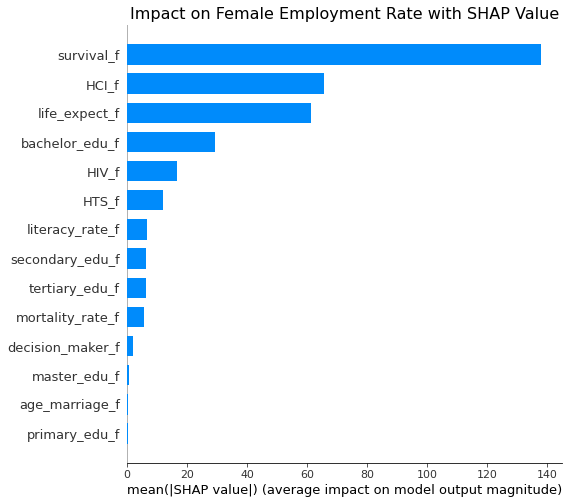

In [ ]:
# Check the SHAP value from regression line
linreg = LinearRegression().fit(feature, target)
masker = shap.maskers.Independent(data=feature)
explainer = shap.LinearExplainer(linreg, masker=masker)
shap_values = explainer(feature)
plt.title('Impact on Female Employment Rate with SHAP Value', fontsize=16)
plt.xlabel("SHAP Value (model impact)")
shap.summary_plot(shap_values, feature, plot_type='bar')

In [ ]:
# Investigate p value to check feature significance
params = np.append(linreg.intercept_,linreg.coef_)
predictions = linreg.predict(feature)

newX = np.append(np.ones((len(feature),1)), feature, axis=1)
MSE = (sum((target-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Features"],myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P_value"] = [
                  ["constant"]+feature_list,params,sd_b,ts_b,p_values]
myDF3.drop(0)

,Features,Coefficients,Standard Errors,t values,P_value
1,primary_edu_f,0.1408,0.352,0.400,0.728
2,secondary_edu_f,0.7265,0.424,1.715,0.228
3,tertiary_edu_f,0.7539,0.621,1.214,0.349
4,bachelor_edu_f,-19.7287,14.484,-1.362,0.306
5,master_edu_f,33.7777,15.166,2.227,0.156
6,life_expect_f,37.7416,22.759,1.658,0.239
7,literacy_rate_f,-2.9416,1.295,-2.272,0.151
8,HCI_f,2777.5137,2514.218,1.105,0.384
9,HTS_f,7.8226,12.840,0.609,0.604
10,age_marriage_f,0.9027,2.109,0.428,0.710


In [ ]:
use_df.to_csv("gender_indicator.csv", index=False)
use_df.head(2)

,Year,emp_rate_f,emp_rate_m,informal_emp_f,formal_emp_f,informal_emp_m,formal_emp_m,primary_edu_f,primary_edu_m,secondary_edu_f,...,age_marriage_f,age_marriage_m,decision_maker_f,decision_maker_m,survival_f,survival_m,population_f,population_m,mortality_rate_f,HIV_f
1,2002,44.243000,79.176002,69.519997,30.48,60.689999,39.310001,90.86566,91.77368,50.48961,...,22.0,25.6,10.711111,31.4,71.278228,64.486552,70340395.0,70792759,167.236,19.0
2,2003,43.830002,78.915001,70.910004,29.09,62.430000,37.570000,89.80657,91.44727,53.10740,...,22.1,25.9,11.133333,31.3,71.895028,64.964118,71404235.0,71921499,165.531,20.3


In [ ]:
# Filter and rename the columns that we'll used for the dashboard graph
dashboard_df = use_df[["Year",'emp_rate_f', "emp_rate_m",
                      'basic_edu_emp_f', 'basic_edu_emp_m', 'interm_edu_emp_f', 'interm_edu_emp_m',
                      'advance_edu_emp_f', 'advance_edu_emp_m',
                      "primary_edu_f", "primary_edu_m",
                      "secondary_edu_f", "secondary_edu_m",
                      "tertiary_edu_f", "tertiary_edu_m",
                      "bachelor_edu_f", "bachelor_edu_m",
                      "master_edu_f", "master_edu_m",
                      "informal_emp_f", "informal_emp_m",
                      "formal_emp_f", "formal_emp_m"]]

dashboard_df.columns = ["Year","% of Woman Population", "% of Man Population",
                        'Female Basic', 'Male Basic', 'Female Intermediate', 
                        'Male Intermediate', "Female Advanced", "Male Advanced",
                        "primary_edu_f", "primary_edu_m",
                        "secondary_edu_f", "secondary_edu_m",
                        "tertiary_edu_f", "tertiary_edu_m",
                        "bachelor_edu_f", "bachelor_edu_m",
                        "master_edu_f", "master_edu_m",
                        "Informal Female", "Informal Male",
                        "Formal Female", "Formal Male"]

In [ ]:
dashboard_df.to_csv("dashboard_data.csv", index=False)
dashboard_df.head(2)

,Year,% of Woman Population,% of Man Population,Female Basic,Male Basic,Female Intermediate,Male Intermediate,Female Advanced,Male Advanced,primary_edu_f,...,tertiary_edu_f,tertiary_edu_m,bachelor_edu_f,bachelor_edu_m,master_edu_f,master_edu_m,Informal Female,Informal Male,Formal Female,Formal Male
1,2002,44.243000,79.176002,44.250000,82.220001,49.340000,85.889999,77.059998,93.080002,90.86566,...,13.75591,15.826860,3.9,4.683750,0.361922,0.626342,69.519997,60.689999,30.48,39.310001
2,2003,43.830002,78.915001,46.779999,83.620003,42.959999,81.139999,63.900002,89.790001,89.80657,...,14.20265,17.788349,4.0,4.984043,0.364198,0.633304,70.910004,62.430000,29.09,37.570000


## Preparation on employment gender data

In [ ]:
female_df = employment_gender("1U-wxQ-isFLe85m_r7_fF0guUTk4CfYWC")
male_df = employment_gender("1gm5M6P4gPaTGh_D50B99iUmQAfHjRbtg")

In [ ]:
# Merge female and male employment data to 1 dataframe
emp_gender_df_raw = np.array([male_df[male_df['Country Name']=='Indonesia'].values[0],
                          female_df[female_df['Country Name']=='Indonesia'].values[0]])
emp_gender_df_raw = pd.DataFrame(emp_gender_df_raw.T, columns=['male','female'], index=male_df.columns).iloc[45:]
emp_gender_df_raw.index = emp_gender_df_raw.index.astype(int)

In [ ]:
emp_gender_df_raw.head(2)

,male,female
2001,80.014,46.259998
2002,79.176002,44.243


In [ ]:
emp_gender_df_raw = emp_gender_df_raw.reset_index().rename(columns={"index":"Year"})
emp_gender_df_raw.to_csv("employment_gender.csv", index=False)
emp_gender_df_raw.head(2)

,Year,male,female
0,2001,80.014,46.259998
1,2002,79.176002,44.243


## Preparation on job skills data

In [ ]:
df = load_data("1rHLCUIpP0ZcLPAcLyIUSIHvVuUT84NA0")
df.head(2)

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."


In [ ]:
df['Minimum Qualifications'][0]

'BA/BS degree or equivalent practical experience.\n3 years of experience in program and/or project management in cloud computing, enterprise software and/or marketing technologies.'

In [ ]:
# Youtube company has less than 2% of the data
df.Company.value_counts()

Google     1227
YouTube      23
Name: Company, dtype: int64

In [ ]:
# We just select google company for the data
df = df[df["Company"]=="Google"]

In [ ]:
# Drop irrelevant columns
df.drop(df.iloc[:,[0,3,4]].columns, axis=1, inplace=True)

In [ ]:
# Drop missing value
df.dropna(inplace=True)
df.isnull().sum().sum()

0

In [ ]:
# Clean text on minimum and preffered qualification
# Then merged it to one
df['clean_minimum'] = df['Minimum Qualifications'].apply(lambda x : clean_text(x, correct=False))
df['clean_preferred'] = df['Preferred Qualifications'].apply(lambda x : clean_text(x, correct=False))
df['Qualification'] = df['clean_minimum'] + df['clean_preferred']
df['temp_qualification'] = df['Qualification'].apply(lambda x: " ".join(x))

In [ ]:
# Drop qualification that is duplicated
df.drop_duplicates(subset='temp_qualification', inplace=True)
# Drop unnecessary columns
df.drop(columns=df.iloc[:,[2,3,4,5,7]].columns, inplace=True)

In [ ]:
df.shape

(820, 3)

In [ ]:
df.to_csv("job_skills_clean.csv", index=False)
df.head(2)

,Title,Category,Qualification
0,Google Cloud Program Manager,Program Management,"[bachelor, art, science, degree, equivalent, p..."
1,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"[bachelor, science, degree, engineering, disci..."


## Recommendation System

In [ ]:
df = load_data("1zHOU1koW4j84AiQY4V4l6pASSzoMJS1x").drop("Unnamed: 0", axis=1)
df.loc[:,"Qualification"] = df["Qualification"].apply(lambda x: ast.literal_eval(x))

In [ ]:
# Cosine similiarity to check similiarity between 2 text
def get_cosine(vec1, vec2):
    vec1 = Counter(vec1)
    vec2 = Counter(vec2)
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [ ]:
# Iterate every job qualification, and check the highest matching
def check_match(df, input, amount=5):
  score = []
  for i in range(df.shape[0]):
    score.append([i, get_cosine(input,df['Qualification'].iloc[i])])
  score = np.array(score)
  score = sorted(score, reverse=True, key=lambda x:x[1])[:amount]
  for i in range(len(score)):
    tmp = df.iloc[int(score[i][0])]
    print(f"Title: {tmp['Title']}\nCategory: {tmp['Category']}\nMatch: {round(score[i][1]*100,2)}%\n")

In [ ]:
# Function to recommend job
def job_recommendation(input, amount=5):
  text = clean_text(input)
  check_match(df, text, amount)

In [ ]:
text = """
BA degree on computer science field. My interests are in processing and analyzing data.
I Have 1 years intership experience in data science. I also have good english skills and I'm a dilligent person.
"""

job_recommendation(text)

Title: Product Analyst, Data Science
Category: Business Strategy
Match: 47.0%

Title: Product Analytics Lead, Data Science
Category: Business Strategy
Match: 46.43%

Title: Data Analyst, Trust and Safety
Category: Product & Customer Support
Match: 41.6%

Title: Data Analyst, Product Trust and Safety
Category: Product & Customer Support
Match: 40.41%

Title: People Operations Business Intelligence Analyst
Category: People Operations
Match: 40.0%

